In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader


In [2]:
FRAME_IR = 5
FRAME_DISTANCE = 20
FEATURE_DIM = 8
LABEL_NUM = 5
BATCH = 5

In [3]:
class CustomDataset(Dataset):
    def __init__(self, IR_dataset, distance_dataset, ground_truth):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.IR_dataset)

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot


In [4]:
# 转换为PyTorch张量并缩放数据
def scale_IR(dataset):
    tensor = torch.tensor(dataset, dtype=torch.float32)
    max_val = 35. # tensor.max()
    min_val = 15. # tensor.min()
    scaled_tensor = (tensor - min_val) / (max_val - min_val)
    return scaled_tensor, max_val, min_val



In [5]:
sampled_distance_dataset, sampled_IR_dataset, groudtruth = make_dataset()
# 示例数据转换
distance_tensor = torch.tensor(np.stack(sampled_distance_dataset, axis=0), dtype=torch.float32)
IR_tensor, max_IR, min_IR = scale_IR(np.stack(sampled_IR_dataset, axis=0))


distance length is 375
IR length is 375
gt length is 375
Distance dataset 1: (20, 2)
IR dataset 1: (5, 64)
Distance dataset 2: (20, 2)
IR dataset 2: (5, 64)


In [6]:
# 神经网络类
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.mlp1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Linear(32, 16),
            # nn.ReLU(),
            nn.Linear(32, FEATURE_DIM),
            nn.ReLU()
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(FRAME_DISTANCE*2, 2*FEATURE_DIM),
            nn.ReLU(),
            # nn.Linear(FEATURE_DIM*2, 2*FEATURE_DIM),
            # nn.ReLU(),
            nn.Linear(FEATURE_DIM*2, 1*FEATURE_DIM),
            nn.ReLU()
        )
        self.mlp3 = nn.Sequential(
            nn.Linear(1*FEATURE_DIM*(FRAME_IR+1), 1*5),
            nn.Softmax(dim=1)
        )

    def forward(self, ir_data, distance_data):
        ir_data = ir_data.view(-1, 64)
        distance_data = distance_data.view(-1, FRAME_DISTANCE*2)

        ir_output = self.mlp1(ir_data)
        distance_output = self.mlp2(distance_data) # 10x4

        ir_output_per_batch = ir_output.view(-1, FRAME_IR*FEATURE_DIM) # 10x16
        combined_output = torch.cat((ir_output_per_batch, distance_output), dim=1)

        final_output = self.mlp3(combined_output)
        return final_output


In [7]:

# 创建数据集和数据加载器
dataset = CustomDataset(IR_tensor, distance_tensor, groudtruth)
# dataloader = DataLoader(dataset, batch_size=BATCH, shuffle=True)


In [8]:
from torch.utils.data import random_split

# 随机分割训练集和测试集，假设80%为训练集，20%为测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, drop_last=True)


In [11]:

# 实例化网络
net = MyNetwork().cuda()


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [12]:
loss_history = []
# 训练循环示例
for epoch in range(500):
    running_loss = 0.0
    for i, (IR_data, distance_data, labels) in enumerate(train_dataloader, 0):
        IR_data = IR_data.cuda()
        distance_data = distance_data.cuda()
        labels = labels.cuda()
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        running_loss += loss.cpu().item()
        if i % 20 == 19:  # 每10个批次打印一次
            loss_mean = running_loss / 20
            loss_history.append(loss_mean)
            print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
            running_loss = 0.0


[1, 20] loss: 1.596
[1, 40] loss: 1.568
[2, 20] loss: 1.540
[2, 40] loss: 1.540
[3, 20] loss: 1.535
[3, 40] loss: 1.551
[4, 20] loss: 1.520
[4, 40] loss: 1.570
[5, 20] loss: 1.514
[5, 40] loss: 1.537
[6, 20] loss: 1.489
[6, 40] loss: 1.571
[7, 20] loss: 1.500
[7, 40] loss: 1.565
[8, 20] loss: 1.508
[8, 40] loss: 1.566
[9, 20] loss: 1.526
[9, 40] loss: 1.539
[10, 20] loss: 1.524
[10, 40] loss: 1.520
[11, 20] loss: 1.509
[11, 40] loss: 1.512
[12, 20] loss: 1.528
[12, 40] loss: 1.515
[13, 20] loss: 1.510
[13, 40] loss: 1.522
[14, 20] loss: 1.522
[14, 40] loss: 1.520
[15, 20] loss: 1.530
[15, 40] loss: 1.503
[16, 20] loss: 1.520
[16, 40] loss: 1.524
[17, 20] loss: 1.490
[17, 40] loss: 1.542
[18, 20] loss: 1.517
[18, 40] loss: 1.518
[19, 20] loss: 1.511
[19, 40] loss: 1.528
[20, 20] loss: 1.517
[20, 40] loss: 1.521
[21, 20] loss: 1.486
[21, 40] loss: 1.526
[22, 20] loss: 1.531
[22, 40] loss: 1.482
[23, 20] loss: 1.519
[23, 40] loss: 1.508
[24, 20] loss: 1.518
[24, 40] loss: 1.498
[25, 20] l

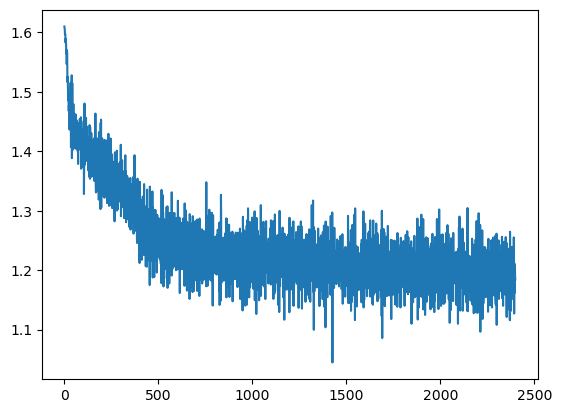

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels) in enumerate(test_dataloader):
        IR_data = IR_data.cuda()
        distance_data = distance_data.cuda()

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8500
Precision: 0.8528
Recall: 0.8723
